In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
nstates = 5
%pwd

'/Users/mahdimac/Science/ML/koopman/TrpCage/SchNet/attn_N_5'

In [3]:
import numpy as np
import scipy.stats


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [4]:
def estimate_koopman_op(trajs, tau):
    if type(trajs) == list:
        traj = np.concatenate([t[:-tau] for t in trajs], axis=0)
        traj_lag = np.concatenate([t[tau:] for t in trajs], axis=0)
    else:
        traj = trajs[:-tau]
        traj_lag = trajs[tau:]
    c_0 = np.transpose(traj)@traj
    c_tau = np.transpose(traj)@traj_lag
    
    eigv, eigvec = np.linalg.eig(c_0)
    include = eigv > 1e-7
    eigv = eigv[include]
    eigvec = eigvec[:, include]
    c0_inv = eigvec @ np.diag(1/eigv) @ np.transpose(eigvec)
    
    koopman_op = c0_inv @ c_tau
    return koopman_op

In [5]:
def get_its(traj, lags):
    '''
    implied timescales from a trajectory estimated at a series of lag times
    
    parameters:
    ----------
    traj: [traj_timesteps, traj_dimensions]
    lags: [lagtimes]
    
    returns:
    ----------
    its: [traj_dim-1, lagtimes]
    '''
    if type(traj) == list:
        outputsize = traj[0].shape[1]
    else:
        outputsize = traj.shape[1]
    its = np.zeros((outputsize-1, len(lags)))
    
    for t, tau_lag in enumerate(lags):
        koopman_op = estimate_koopman_op(traj, tau_lag)
        k_eigvals, k_eigvec = np.linalg.eig(np.real(koopman_op))
        k_eigvals = np.sort(np.absolute(k_eigvals))
        k_eigvals = k_eigvals[:-1]
        its[:,t] = (-tau_lag/np.log(k_eigvals))
    return its

In [6]:
transformed = []
for i in range(1,11):
    trans_temp = []
    trans_temp.append(np.load('trans_'+str(i)+'.npz')['arr_0'])
    transformed.append(trans_temp) 

In [7]:
# take the argmax of each prob vector for hard state assignment
all_trajs = []
for i in range(len(transformed)):
    trajs = []
    for j in range(1): # 1 trajectory
        traj = []
        for k in range(len(transformed[0][j])): # length of each trajectory         
            traj.append(transformed[i][j][k].argmax())
        traj = np.array(traj)
        trajs.append(traj)
    
    all_trajs.append(trajs)

In [8]:
y_m_t = []
inds = []
thresh = 0.95
exp = 0
for i in range(1):
    tmp = []
    tmp_ind = []
    for j in range(len(transformed[exp][i])):
        if transformed[exp][i][j].max()>thresh:
            tmp.append(np.argmax(transformed[exp][i][j]))
            tmp_ind.append(j)
    tmp = np.array(tmp)
    tmp_ind = np.array(tmp_ind)
        
    y_m_t.append(tmp)
    inds.append(tmp_ind)

In [9]:
unique = []
for i in range(1):
    unique.append(np.unique(y_m_t[i]))
unique = np.unique(np.concatenate(np.array(unique)))

In [10]:
# probability of each state in 0 experiment
state_prob0 = [sum(all_trajs[0][0]==i)/len(all_trajs[0][0]) for i in range(nstates)] # state prob in exp_0

In [11]:
state_prob = np.array(state_prob0)

In [13]:
state_prob*100 # state probabilities

array([ 1.06752874, 69.50478927,  1.60727969, 10.0335249 , 17.78687739])

In [14]:
sorted = np.argsort(state_prob)[::-1] # sort them descending

In [15]:
# the relation between states of different experiments
nstates = 5
state_rel = []
for i in range(10):
    rel = []
    for index in sorted:
        count = np.zeros(nstates)
        for j in range(1): # number of trajectories
            a = all_trajs[i][j][all_trajs[0][j]==index]
            # count the numbers
            for k in range(nstates):
                count[k] = count[k] + np.sum([a==k])

        sorted_count = np.argsort(count)[::-1]
        if sorted_count[0] not in rel:
            rel.append(sorted_count[0])
        elif sorted_count[1] not in rel:
            rel.append(sorted_count[1])    
        elif sorted_count[2] not in rel:
            rel.append(sorted_count[2])
        elif sorted_count[3] not in rel:
            rel.append(sorted_count[3])
        elif sorted_count[4] not in rel:
            rel.append(sorted_count[4])
        else:
            rel.append(sorted_count[5])
        
    rel = np.array(rel)
    state_rel.append(rel)

In [16]:
# sort the states based on the first experiment
all_probs = []
for i in range(10): # number of experiments
    trans = transformed[i]
    probs = []
    if i==0:
        for k in range(1): # number of trajectories
            prob = []
            for j in range(len(trans[k])):
                prob.append(trans[k][j][sorted])
            prob = np.array(prob)
            probs.append(prob)
        all_probs.append(probs)
    else:
        for k in range(1): # number of trajectories
            prob = []
            for j in range(len(trans[k])):
                prob.append(trans[k][j][state_rel[i-1]])
            prob = np.array(prob)
            probs.append(prob)
        all_probs.append(probs)

In [17]:
lags = np.arange(1,201,2, dtype=np.int32)

In [18]:
its = []
for i in range(10): # number of experiments
    its.append(get_its(all_probs[i], lags))

In [19]:
its = np.array(its)

In [20]:
mean_its = np.zeros((nstates,100))
up_its = np.zeros((nstates,100))
down_its = np.zeros((nstates,100))

In [21]:
for i in range(nstates-1):
    for j in range(len(lags)):
        mean_its[i,j], up_its[i,j], down_its[i,j] = mean_confidence_interval(its[:,i,j])

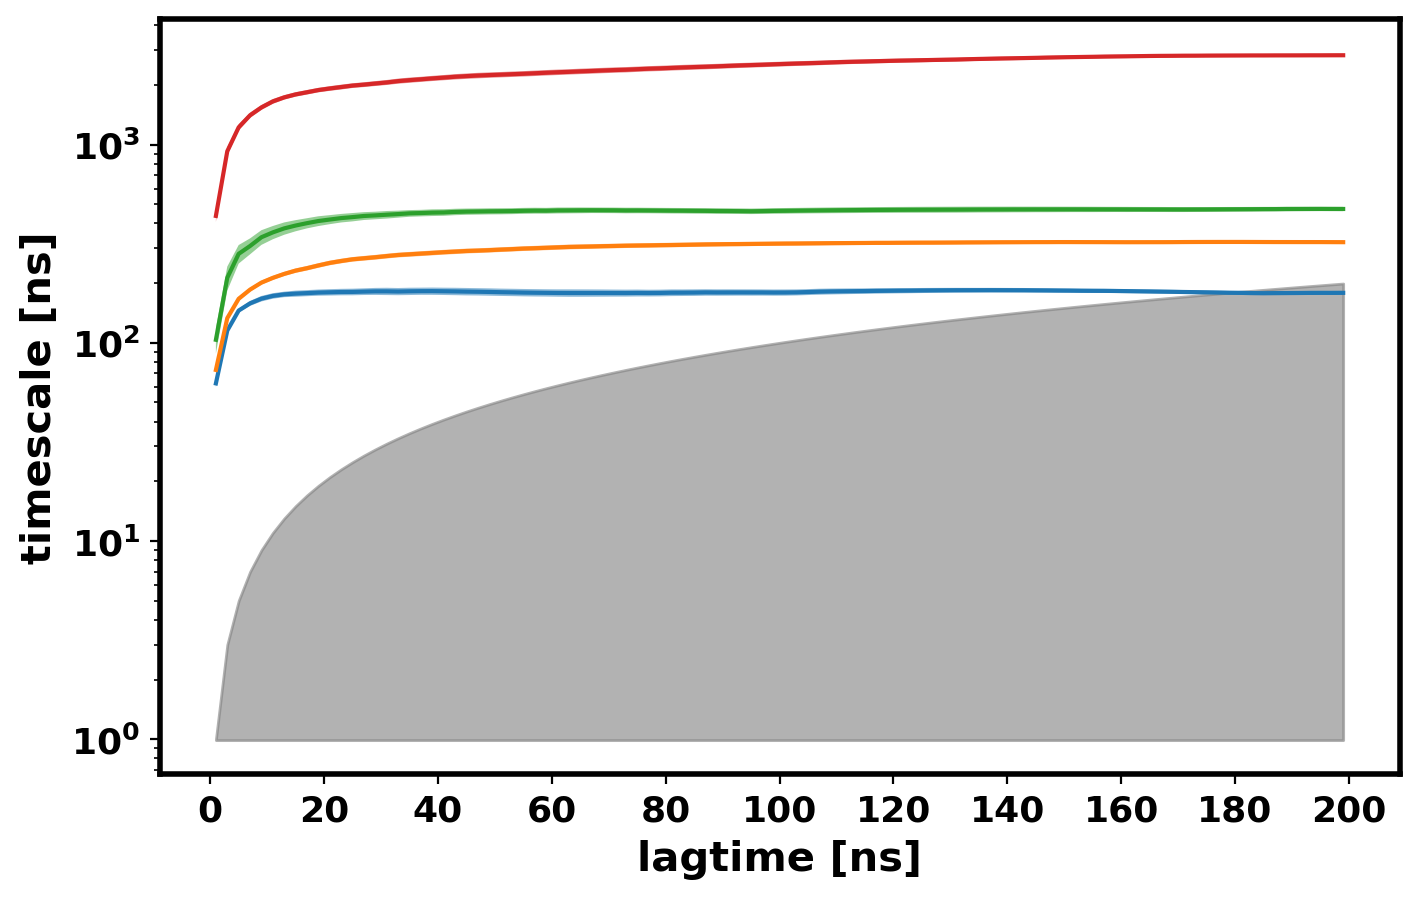

In [22]:
from pylab import *
rc('axes', linewidth=2)
f, ax = plt.subplots(1,1, figsize=(8,5), dpi=200)


for index in range(0,nstates):
    ax.semilogy(lags, mean_its[index])
    ax.fill_between(lags, down_its[index], up_its[index], alpha=0.5)

ax.set_xticks(np.arange(0,201,20))
ax.set_xticklabels([0,20,40,60,80,100,120,140,160,180,200])
ax.fill_between(lags, lags, 0.99, alpha=0.6, color='grey')

ax.set_xlabel('lagtime [ns]', fontweight='bold', fontsize=15)
ax.set_ylabel('timescale [ns]', fontweight='bold', fontsize=15)


fontsize = 13
ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')

plt.savefig('trpcage_its.png')

In [23]:
def get_ck_test(traj, steps, tau):
    if type(traj) == list:
        n_states = traj[0].shape[1]
    else:
        n_states = traj.shape[1]
    
    predicted = np.zeros((n_states, n_states, steps))
    estimated = np.zeros((n_states, n_states, steps))
    
    predicted[:,:,0] = np.identity(n_states)
    estimated[:,:,0] = np.identity(n_states)
    
    for vector, i in zip(np.identity(n_states), range(n_states)):
        for n in range(1,steps):
            koop = estimate_koopman_op(traj, tau)
            koop_pred = np.linalg.matrix_power(koop,n)
            koop_est = estimate_koopman_op(traj, tau*n)
            
            predicted[i,:,n] = vector @ koop_pred
            estimated[i,:,n] = vector @ koop_est
    
    return [predicted, estimated]

In [24]:
preds = []
ests = []
for i in range(10):
    pred, est = get_ck_test(transformed[i], steps=10, tau=20)
    preds.append(pred)
    ests.append(est)

In [25]:
preds = np.array(preds)
ests = np.array(ests)

In [26]:
pred_ord = []
est_ord = []
for i in range(10):
    pred_ord.append(preds[i][state_rel[i][:,None],state_rel[i][None,:]])
    est_ord.append(ests[i][state_rel[i][:,None],state_rel[i][None,:]])

pred_ord = np.array(pred_ord)
est_ord = np.array(est_ord)

In [27]:
mean_pred = np.zeros((nstates,nstates,10))
up_pred = np.zeros((nstates,nstates,10))
down_pred = np.zeros((nstates,nstates,10))

In [28]:
mean_est = np.zeros((nstates,nstates,10))
up_est = np.zeros((nstates,nstates,10))
down_est = np.zeros((nstates,nstates,10))

In [29]:
for i in range(nstates):
    for j in range(nstates):
        for k in range(10):
            mean_pred[i,j,k], up_pred[i,j,k], down_pred[i,j,k] = mean_confidence_interval(pred_ord[:,i,j,k], confidence=0.95)

In [30]:
for i in range(nstates):
    for j in range(nstates):
        for k in range(10):
            mean_est[i,j,k], up_est[i,j,k], down_est[i,j,k] = mean_confidence_interval(est_ord[:,i,j,k], confidence=0.95)

In [31]:
from matplotlib import rc, rcParams
from pylab import *

rc('axes', linewidth=2)
fontsize = 14

/var/folders/0h/0c2jt73s6vb8x8ndmgjr26nh0000gn/T/ipykernel_81062/1906583158.py:28: UserWarning: Legend does not support array([[1.        , 0.98291892, 0.96722282, 0.95278681, 0.9394978 ,
        0.92725329, 0.91596037, 0.90553479, 0.89590012, 0.88698703],
       [0.        , 0.00223399, 0.00441122, 0.00653523, 0.00860924,
        0.01063622, 0.01261884, 0.01455958, 0.0164607 , 0.01832426],
       [0.        , 0.0096552 , 0.01850134, 0.02660543, 0.03402888,
        0.04082795, 0.04705422, 0.05275496, 0.05797351, 0.06274961],
       [0.        , 0.00140911, 0.00273808, 0.00399179, 0.0051748 ,
        0.00629134, 0.00734537, 0.0083406 , 0.00928047, 0.01016822],
       [0.        , 0.00378277, 0.00712654, 0.01008073, 0.01268927,
        0.0149912 , 0.0170212 , 0.01881007, 0.0203852 , 0.02177089]]) instances.
A proxy artist may be used instead.
See: https://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  fig.legend([pred[0],

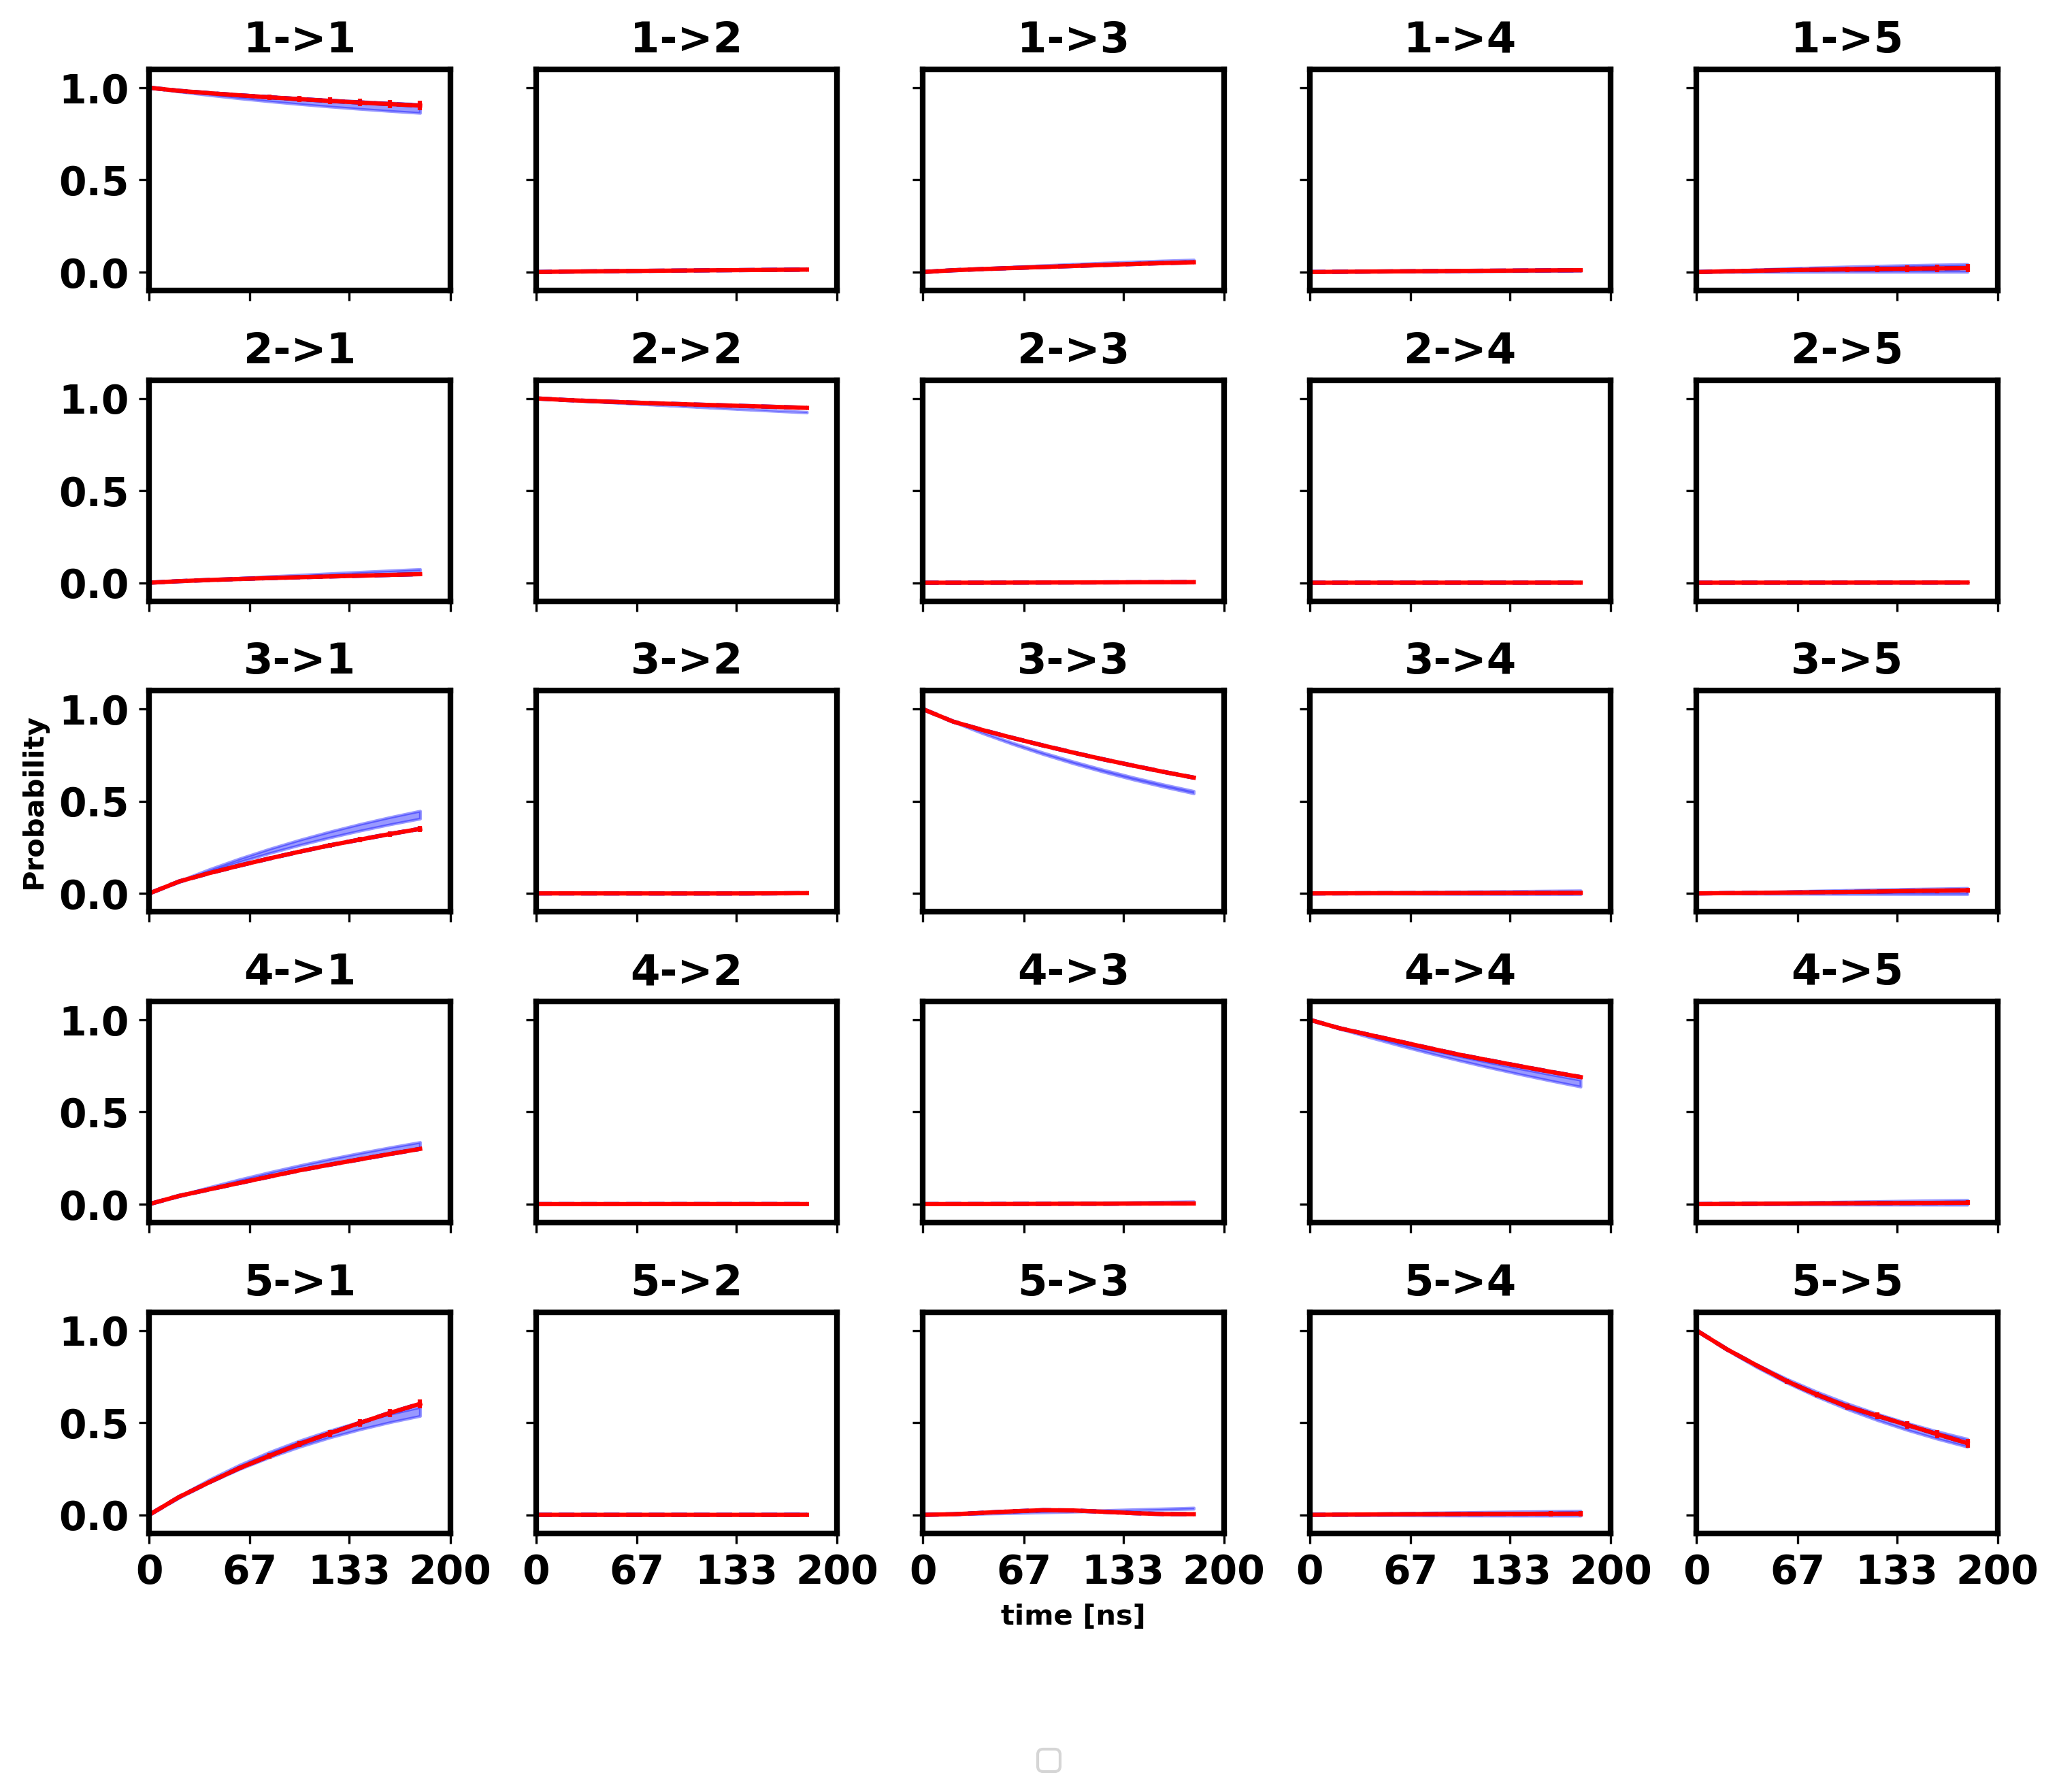

In [32]:
n_states = 5
steps = 10
tau = 20
pred = mean_pred
est = mean_est

fontsize = 14
fig, ax = plt.subplots(n_states, n_states, sharex=True, sharey=True, figsize=(10,8),dpi=300)
for index_i in range(n_states):
    for index_j in range(n_states):

        ax[index_i][index_j].plot(range(0, steps*tau, tau), est[index_i, index_j], color='b', linestyle='--')
        #ax[index_i][index_j].plot(range(0, steps*tau, tau), est[index_i, index_j], color='r', linestyle='--')
        ax[index_i][index_j].fill_between(range(0, steps*tau, tau), down_pred[index_i, index_j], up_pred[index_i, index_j], alpha=0.4, color='blue')
        ax[index_i][index_j].set_title(str(index_i+1)+'->'+str(index_j+1), fontweight='bold', fontsize=15)
        ax[index_i][index_j].errorbar(range(0, steps*tau, tau), est[index_i, index_j], est[index_i,index_j]-down_est[index_i, index_j], color='red')

        for tick in ax[index_i][index_j].xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('bold')
        for tick in ax[index_i][index_j].yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            tick.label1.set_fontweight('bold')
ax[0][0].set_ylim((-0.1, 1.1))
ax[0][0].set_xlim((0, steps*tau))
ax[0][0].axes.get_xaxis().set_ticks(np.round(np.linspace(0, steps*tau, 4)))
plt.tight_layout()
fig.legend([pred[0], est[0]], ['Estimates', 'Predicted'], 'lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))
ax[n_states-1, n_states//2].set_xlabel('time [ns]', fontweight='bold')
ax[n_states//2, 0].set_ylabel('Probability', fontweight='bold')



plt.savefig('trpcage_ck.png')

# Attention results

In [33]:
y_m_t = []
inds = []
thresh = 0.95
exp = 0
for i in range(1):
    tmp = []
    tmp_ind = []
    for j in range(len(transformed[exp][i])):
        if transformed[exp][i][j].max()>thresh:
            tmp.append(np.argmax(transformed[exp][i][j]))
            tmp_ind.append(j)
    tmp = np.array(tmp)
    tmp_ind = np.array(tmp_ind)
        
    y_m_t.append(tmp)
    inds.append(tmp_ind)

In [34]:
traj_inds = inds

In [37]:
attn = np.load('avg_attn.npz')['arr_0']
inds = np.load('../../inds_trpcage_ca_7nbrs_1ns.npz')['arr_0']

In [38]:
def convert_adj(mat, attn):
    # convert the nbr_adj_list matrix to an adjacency matrix
    adj = np.zeros((mat.shape[0], mat.shape[1], mat.shape[1]))
    for i in range(mat.shape[0]):
        adj[i][np.arange(adj.shape[1])[:,None],mat[i]] = attn[i]
    return adj

In [39]:
adj = convert_adj(inds, attn)

In [40]:
score_0 = adj[all_trajs[0][0]==0].mean(axis=0)
score_1 = adj[all_trajs[0][0]==1].mean(axis=0)
score_2 = adj[all_trajs[0][0]==2].mean(axis=0)
score_3 = adj[all_trajs[0][0]==3].mean(axis=0)
score_4 = adj[all_trajs[0][0]==4].mean(axis=0)

In [41]:
st_0 = traj_inds[0][y_m_t[0] == 0]
st_1 = traj_inds[0][y_m_t[0] == 1]
st_2 = traj_inds[0][y_m_t[0] == 2]
st_3 = traj_inds[0][y_m_t[0] == 3]
st_4 = traj_inds[0][y_m_t[0] == 4]

In [42]:
adj_0 = adj[st_0].mean(axis=0)
adj_1 = adj[st_1].mean(axis=0)
adj_2 = adj[st_2].mean(axis=0)
adj_3 = adj[st_3].mean(axis=0)
adj_4 = adj[st_4].mean(axis=0)

<Figure size 432x288 with 0 Axes>

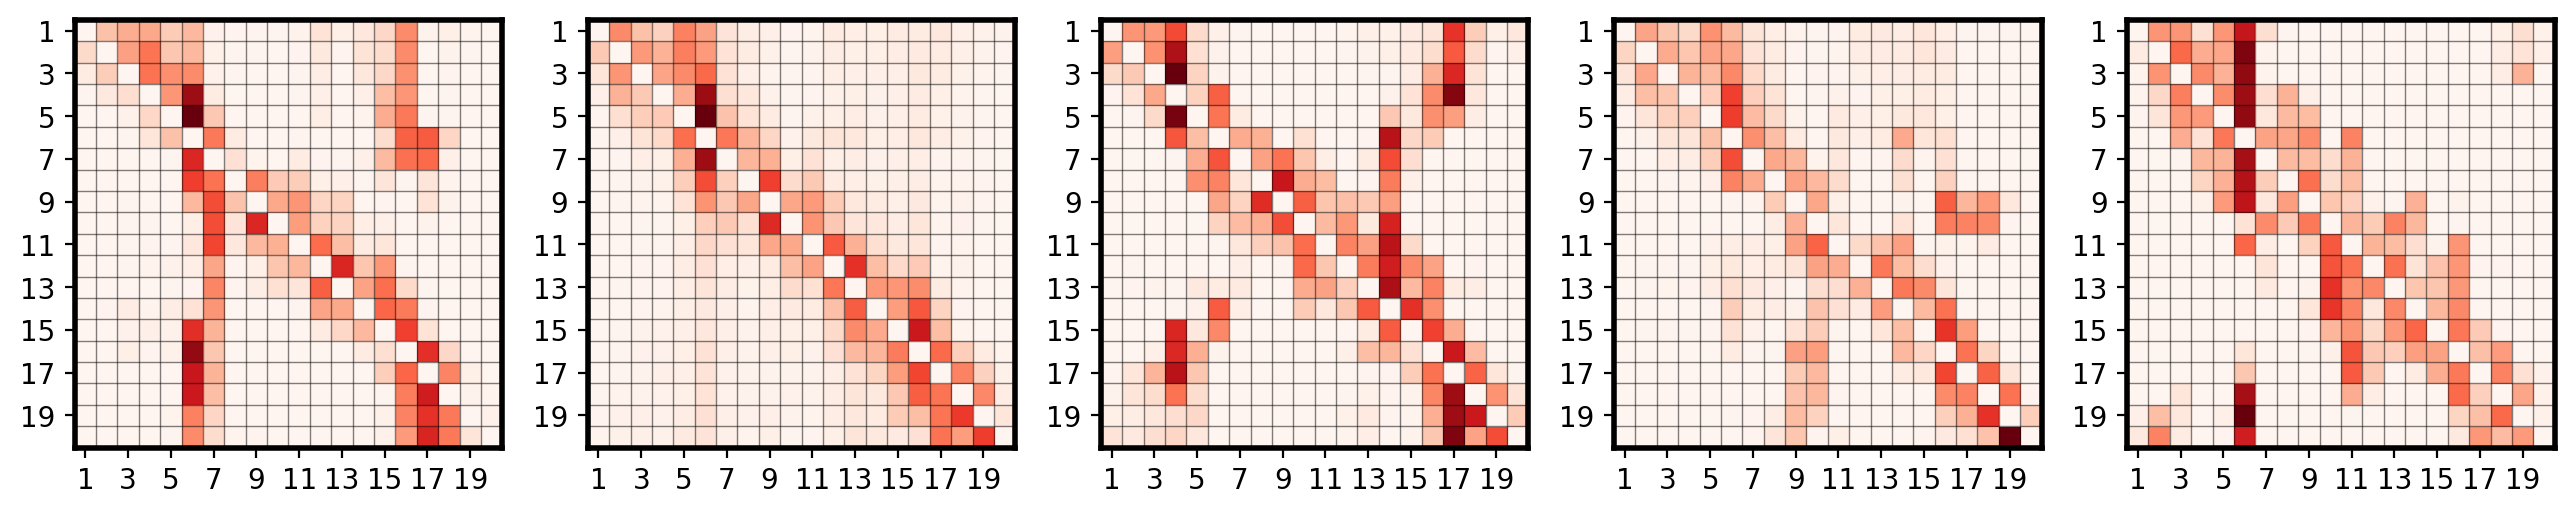

In [43]:
plt.set_cmap('Reds')
fig, axes = plt.subplots(1,5,figsize=(16,3),dpi=200)

axes[0].imshow(score_0)
axes[0].hlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[0].vlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[0].set_xticks(np.arange(0,20,2))
axes[0].set_xticklabels(np.arange(1,21,2))
axes[0].set_yticks(np.arange(0,20,2))
axes[0].set_yticklabels(np.arange(1,21,2))
axes[1].imshow(score_1)
axes[1].hlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[1].vlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[1].set_xticks(np.arange(0,20,2))
axes[1].set_xticklabels(np.arange(1,21,2))
axes[1].set_yticks(np.arange(0,20,2))
axes[1].set_yticklabels(np.arange(1,21,2))
axes[2].imshow(score_2)
axes[2].hlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[2].vlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[2].set_xticks(np.arange(0,20,2))
axes[2].set_xticklabels(np.arange(1,21,2))
axes[2].set_yticks(np.arange(0,20,2))
axes[2].set_yticklabels(np.arange(1,21,2))
axes[3].imshow(score_3)
axes[3].hlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[3].vlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[3].set_xticks(np.arange(0,20,2))
axes[3].set_xticklabels(np.arange(1,21,2))
axes[3].set_yticks(np.arange(0,20,2))
axes[3].set_yticklabels(np.arange(1,21,2))
axes[4].imshow(adj_4)
axes[4].hlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[4].vlines(np.arange(0,20)-0.5,-0.5,19.5,color='k',linewidth=0.5,alpha=0.5)
axes[4].set_xticks(np.arange(0,20,2))
axes[4].set_xticklabels(np.arange(1,21,2))
axes[4].set_yticks(np.arange(0,20,2))
axes[4].set_yticklabels(np.arange(1,21,2))
fig.savefig('trpcage_attn.png')

In [44]:
def scale(score):
    score_min = score.min()
    score_max = score.max()
    ret = (score-score_min)/(score_max-score_min)
    return ret

In [47]:
scores = np.stack((scale(score_0.sum(axis=0)), scale(score_1.sum(axis=0)), scale(score_2.sum(axis=0)), scale(score_3.sum(axis=0)), scale(score_4.sum(axis=0))))

In [48]:
residues = ['ASP1','ALA2','TYR3','ALA4','GLN5','TRP6','LEU7','ALA8',
           'ASP9','GLY10','GLY11','PRO12','SER13','SER14','GLY15', 'ARG16',
           'PRO17','PRO18','PRO19','SER20']

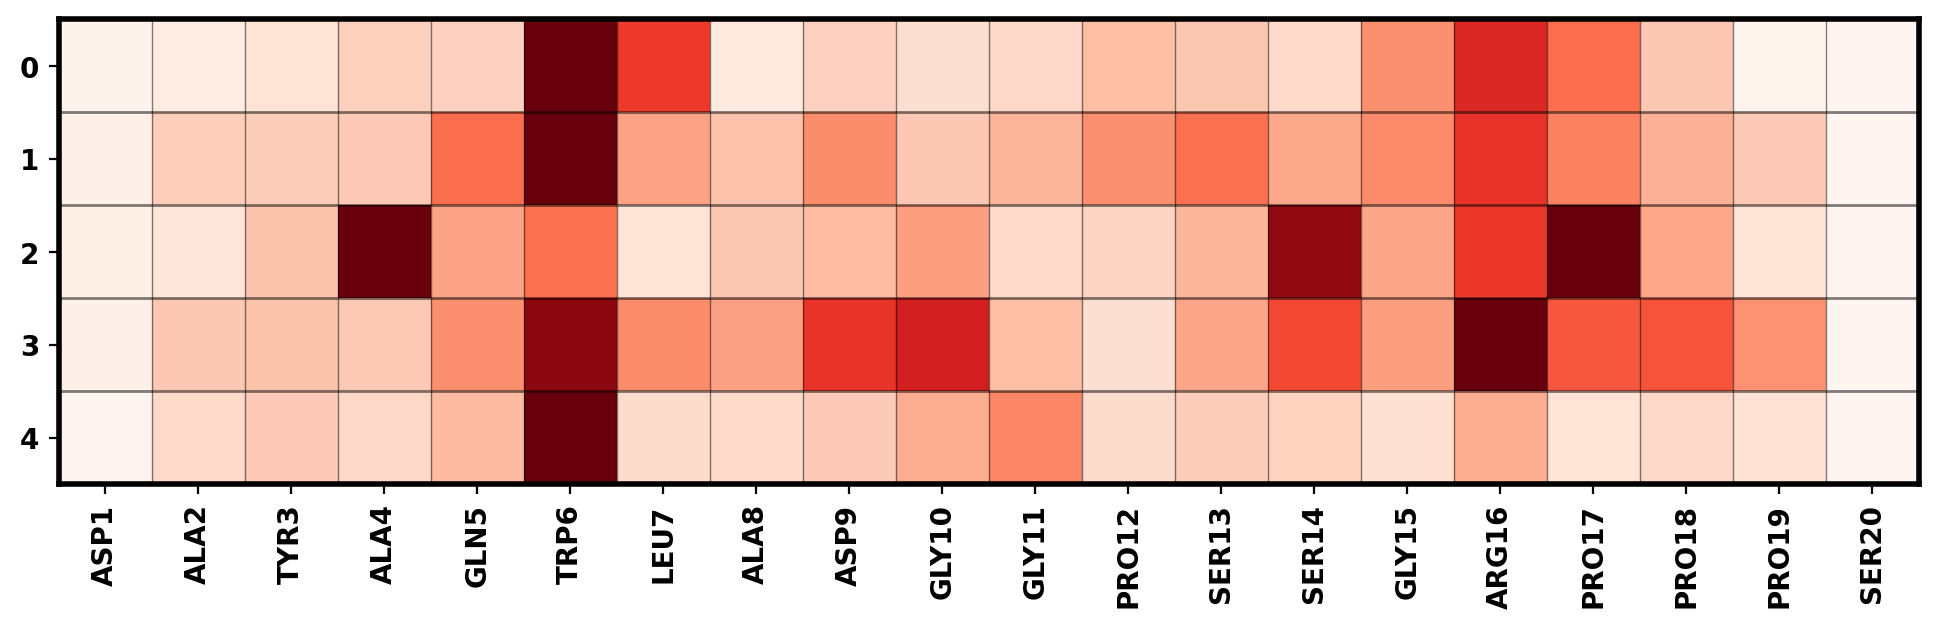

In [52]:
fig, ax = plt.subplots(1,1,figsize=(12,6),dpi=200)
h=ax.imshow(scores)
ax.set_xticks(np.arange(20))
ax.set_xticklabels(residues,fontweight='bold', rotation=90)
ax.hlines(np.arange(0,5)-0.5,-0.5,19.5,color='k',linewidth=1,alpha=0.5)
ax.vlines(np.arange(0,20)-0.5,-0.5,4.5,color='k',linewidth=0.5,alpha=0.5)
#cbar = plt.colorbar(h, ax=ax)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(25)

fontsize = 10
ax = gca()

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(fontsize)
    tick.label1.set_fontweight('bold')
    
plt.savefig('trpcage_attn_all.png')